# Краткое описание датасета
датасет представляет собой набор данных о работниках некоторой компании.

датасет взят из https://www.kaggle.com/datasets/dev0914sharma/customer-clustering

### Атрибуты

 *   ID - уникальный номер работника
 *   Sex - пол
 *   Marital status - семейное положение
 *   Age - возраст
 *   Education - полученное образование
 *   Income - доход
 *   Occupation - профессия
 *   Settlement size - размер населенного пункта, где проживает работник

 В данном датасете категориальные переменные сразу закодированы целочисленными значениями.

# Первичная обработка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('segmentation data.csv')
df.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [4]:
df.isnull().sum()

ID                 0
Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

In [5]:
df.nunique()

ID                 2000
Sex                   2
Marital status        2
Age                  58
Education             4
Income             1982
Occupation            3
Settlement size       3
dtype: int64

In [6]:
df.shape, df.drop_duplicates().shape

((2000, 8), (2000, 8))

Дубликаты и пустые значения отсутствуют

<Axes: xlabel='Income', ylabel='Count'>

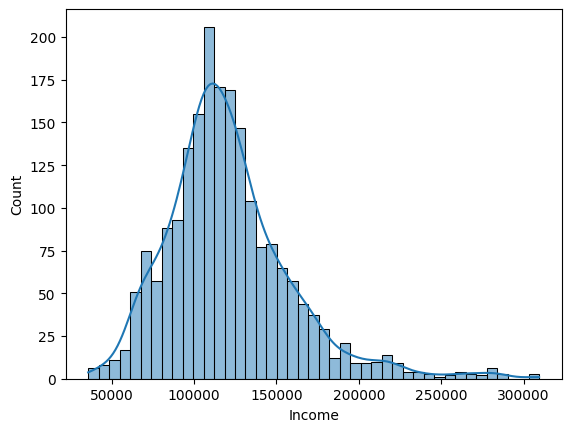

In [7]:
sns.histplot(df['Income'], kde=True)

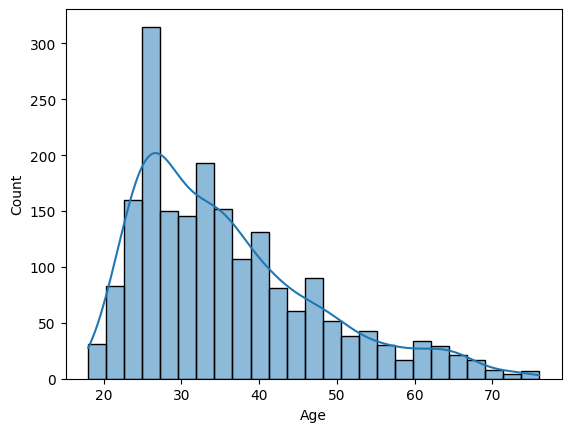

In [8]:
sns.histplot(df['Age'], kde=True)
plt.show()

### Добавление дополнительной переменной

Будет добавлена категориальная переменная Income_status, обозначающая категорию заработка. Имеет три значения: 0, 1, 2. 0 - низкий заработок, 1 - средний заработок, 2 - высокий заработок.

In [9]:
def income_status(x):
    if x <= 60_000:
        return 0  # Low income
    elif 60_000 < x <= 150_000:
        return 1  # Average income
    elif x > 150_000:
        return 2  # High income

df['Income_status'] = df['Income'].apply(income_status)
df.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Income_status
0,100000001,0,0,67,2,124670,1,2,1
1,100000002,1,1,22,1,150773,1,2,2
2,100000003,0,0,49,1,89210,0,0,1
3,100000004,0,0,45,1,171565,1,1,2
4,100000005,0,0,53,1,149031,1,1,1


# Отношение количественных переменных друг к другу


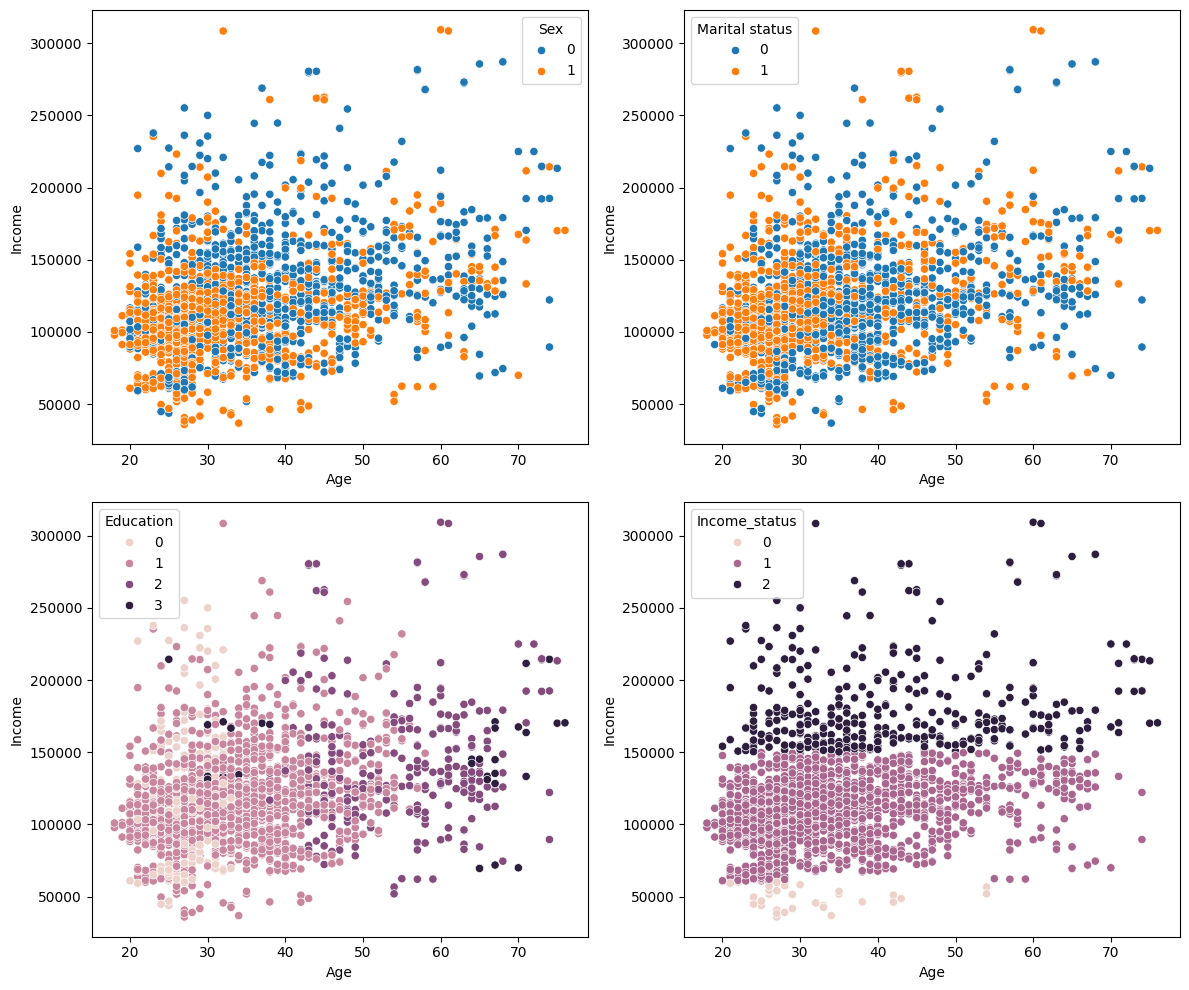

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(data=df,
                x='Age',
                y='Income',
                hue='Sex',
                ax=axes[0, 0])

sns.scatterplot(data=df,
                x='Age',
                y='Income',
                hue='Marital status',
                ax=axes[0, 1])

sns.scatterplot(data=df,
                x='Age',
                y='Income',
                hue='Education',
                ax=axes[1, 0])

sns.scatterplot(data=df,
                x='Age',
                y='Income',
                hue='Income_status',
                ax=axes[1, 1])

plt.tight_layout()
plt.show()

Четко видных кластеров не наблюдается (кроме разделения по income_status. Такая четка границы создана искусственно, т.к была задана в функции), однако размытые границы кластеров видны при разделении по education. Также можно заметить, что чем старше человек, тем выше его уровень образования.

# Подготовка данных для обучения модели

In [11]:
X = df.drop(columns=['ID'])

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [12]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.844828,0.666667,0.324781,0.5,1.0,0.5
1,1.0,1.0,0.068966,0.333333,0.420210,0.5,1.0,1.0
2,0.0,0.0,0.534483,0.333333,0.195144,0.0,0.0,0.5
3,0.0,0.0,0.465517,0.333333,0.496223,0.5,0.5,1.0
4,0.0,0.0,0.603448,0.333333,0.413842,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...
1995,1.0,0.0,0.500000,0.333333,0.320595,0.0,0.0,0.5
1996,1.0,1.0,0.155172,0.333333,0.299460,0.5,0.0,0.5
1997,0.0,0.0,0.224138,0.000000,0.184871,0.0,0.0,0.5
1998,1.0,1.0,0.103448,0.333333,0.227162,0.0,0.0,0.5


# Обучение модели

In [13]:
models = [KMeans(n_clusters=n).fit(X) for n in range(2, 11)]
scores = pd.DataFrame(columns=['n_clusters', 'inertia', 'silhoette_score'])

for n in range(2, 11):
    print(f'KMeans with {n} clusters:')
    model = KMeans(n_clusters=n)
    model.fit(X)
    print(f'Inertia: {model.inertia_}')
    print(f'Silhouette score: {silhouette_score(X, model.labels_)}')
    print('\n')
    scores.loc[len(scores)] = [n, model.inertia_, silhouette_score(X, model.labels_)]

KMeans with 2 clusters:
Inertia: 1137.1531937299756
Silhouette score: 0.3643829377457278


KMeans with 3 clusters:
Inertia: 912.4401694441609
Silhouette score: 0.3370384610051127


KMeans with 4 clusters:
Inertia: 750.1797241704337
Silhouette score: 0.3522345068177774


KMeans with 5 clusters:
Inertia: 589.1550603510333
Silhouette score: 0.39468406718770077


KMeans with 6 clusters:
Inertia: 553.435367782311
Silhouette score: 0.32261322500585005


KMeans with 7 clusters:
Inertia: 441.00356019595694
Silhouette score: 0.37680095681704107


KMeans with 8 clusters:
Inertia: 403.4251884399712
Silhouette score: 0.4003078547135742


KMeans with 9 clusters:
Inertia: 360.7654345878668
Silhouette score: 0.38890785890495094


KMeans with 10 clusters:
Inertia: 344.7727823797542
Silhouette score: 0.40157952812876396




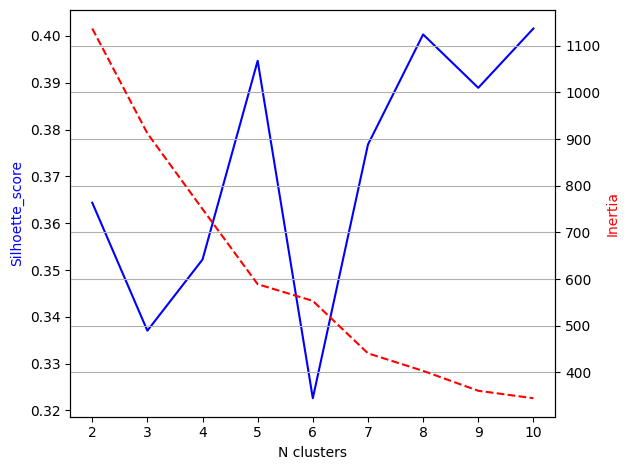

In [14]:
fig, ax1 = plt.subplots()

ax1.plot(scores['n_clusters'], scores['silhoette_score'], 'b-', label='Silhoette score')
ax1.set_xlabel('N clusters')
ax1.set_ylabel('Silhoette_score', color='b')

ax2 = ax1.twinx()
ax2.plot(scores['n_clusters'], scores['inertia'], 'r--', label='Inertia')
ax2.set_ylabel('Inertia', color='r')

fig.tight_layout()
plt.grid()
plt.show()


Интерпретация метрик:
* Если inertia значительно уменьшится при увеличении числа кластеров, это может
указывать на то, что большее количество кластеров лучше подстраивается под данные. Однако вы должны быть осторожны, так как можно достичь очень низкого значения инертности, если выбор кластеров будет слишком большой, что может привести к переобучению.
*  Чем выше Silhouette Score, тем лучше кластеризация. Значение близкое к 1 указывает на хорошую сегментацию данных. Значения около 0 могут указывать на неопределенность в распределении данных по кластерам.


# Вывод

При увеличении числа кластеров inertia постепенно снижается (от 1150 при 2х кластерах до 350 при 10 кластерах).
При этом silhoette_score достигает максимального значения в 0.4 при 7 кластерах.
Данные результаты говорят о том, что кластеризация не совсем оптимальна. Возможно, результаты могут быть улучшены при изменении алгоритма кластеризации и/или более глубокой предобработке данных.